In [44]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [6]:
file_path = "../data/fulldata.csv"
data = pd.read_csv(file_path, low_memory = False)

In [7]:
data.head()

,Unnamed: 0,year,round,from_country,to_country,total_points,tele_points,jury_points,Year_from,iso-alpha-3_from,...,city_to,lat_to,lon_to,GDP per capita (current US$)_to,"Population, total_to",distance,jaccard_artists,jaccard_genre,dice_genre,dice_artists
0,0,1960,final,at,fr,1,NaN,NaN,1960,AUT,...,Paris,3.760847e+06,2.889644e+06,1302.53149729892,47412964,1036.040752,0.153846,0.090909,0.166667,0.266667
1,1,1960,final,at,gb,3,NaN,NaN,1960,AUT,...,London,3.620981e+06,3.203213e+06,1397.5948032844,52400000,1237.492544,0.302326,0.224490,0.366667,0.464286
2,2,1960,final,at,mc,0,NaN,NaN,1960,AUT,...,Monaco,4.111648e+06,2.295892e+06,..,21808,852.872041,0.111111,0.200000,0.333333,0.200000
3,3,1960,final,at,no,1,NaN,NaN,1960,AUT,...,Oslo,4.362948e+06,4.091117e+06,1451.2850779894,3581239,1353.489212,0.292683,0.200000,0.333333,0.452830
4,4,1960,final,at,de,2,NaN,NaN,1960,AUT,...,Berlin,4.551651e+06,3.273670e+06,1162.12266831735,72814900,524.812724,0.666667,0.666667,0.800000,0.800000


## Overall Linear Regression for distance

First, we want to investigate whether the overall distance between the capitals of voting and receiving countries has a significant impact on the average points awarded in the Grand Final over the years.

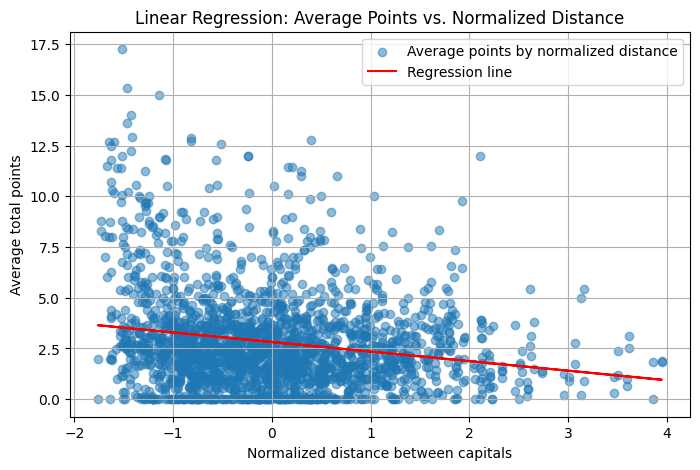

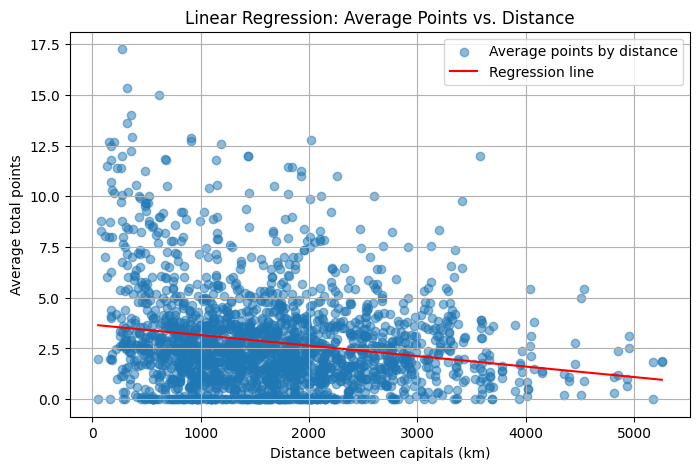

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     83.31
Date:                Sat, 25 Jan 2025   Prob (F-statistic):           1.61e-19
Time:                        17:01:33   Log-Likelihood:                -4761.7
No. Observations:                2092   AIC:                             9527.
Df Residuals:                    2090   BIC:                             9539.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.8188    

In [11]:
# IMPORTANT: No Australia and only Grand Final votes
data1 = data[(data["from_country"] != "au") & (data["to_country"] != "au") & (data["round"] == "final")] 
aggregated_data = data1.groupby(["from_country", "to_country"], as_index = False).agg({
    "total_points": "mean",     # Average points awarded
    "distance": "mean"          # Distance
})

distance_mean = aggregated_data["distance"].mean()
distance_std = aggregated_data["distance"].std()
aggregated_data["distance_normalized"] = (aggregated_data["distance"] - distance_mean) / distance_std
aggregated_data

X_agg = sm.add_constant(aggregated_data["distance_normalized"])
Y_agg = aggregated_data["total_points"]

agg_model = sm.OLS(Y_agg, X_agg).fit()      # Ordinary Least Squares for Linear Regression
agg_summary = agg_model.summary()

x_plot_original = np.linspace(aggregated_data["distance"].min(), aggregated_data["distance"].max(), 100)        # Unnormalized distance predictions back to original scale for plotting
x_plot_normalized = (x_plot_original - distance_mean) / distance_std
x_plot_with_const = sm.add_constant(x_plot_normalized)
y_plot = agg_model.predict(x_plot_with_const)

plt.figure(figsize=(8, 5))
plt.scatter(aggregated_data['distance_normalized'], aggregated_data['total_points'], alpha=0.5, label='Average points by normalized distance')
plt.plot(aggregated_data['distance_normalized'], agg_model.predict(X_agg), color='red', label='Regression line')
plt.title('Linear Regression: Average Points vs. Normalized Distance')
plt.xlabel('Normalized distance between capitals')
plt.ylabel('Average total points')
plt.legend()
plt.grid(True)
plt.savefig("../plots/linear_regression/overall_normalized.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(aggregated_data["distance"], aggregated_data["total_points"], alpha=0.5, label="Average points by distance")
plt.plot(x_plot_original, y_plot, color="red", label="Regression line")
plt.title("Linear Regression: Average Points vs. Distance")
plt.xlabel("Distance between capitals (km)")
plt.ylabel("Average total points")
plt.legend()
plt.grid(True)
plt.savefig("../plots/linear_regression/overall.png")
plt.show()

print(agg_summary)


### Results explanation

· R-squared: 0.038 → Only 3.8% of the variance in the average points awarded can be explained by the distance, so distance is not a strong predictor of the overall voting behavior.

· Prob (F-statistic): 1.61e-19 → The very low p-value (<0.05) indicates that the overall model is statistically significant, meaning that distance should have some effect on Eurovision voting, but very small.

· Coefficients:

- Intercept (const): 2.8188 → Represents the predicted average points a country at an average distance from another country would receive.

- Distance Coefficient (normalized): -0.4706 → For every 1-standard deviation increase in distance, the expected number of points decreases by that amount.

- p-value (P>|t|): 0.000 → The effect of distance is highly statistically significant (unlikely to be due to random chance).

### Conclusion

Though statistically significant, this effect is very small in magnitude, suggesting that distance only slightly reduces the points awarded.

While distance has a small but significant negative impact on points awarded, the low R-squared suggests that other factors—such as cultural, political, and historical ties—likely play a much larger role

## Overall Linear Regression with multiple factor (distance, GDP, music preferences)

Fist, we have to select and normalize the data we are going to use:

In [37]:
data2 = data[(data["from_country"] != "au") & (data["to_country"] != "au") & (data["round"] == "final")] 

columns_to_use = ['total_points', 'distance','GDP per capita (current US$)_from', 'GDP per capita (current US$)_to', 'dice_genre', 'dice_artists']
data2.replace("..",float("nan"),inplace=True)
filtered_data = data2[columns_to_use].dropna()

filtered_data["GDP per capita (current US$)_from"] = pd.to_numeric(filtered_data["GDP per capita (current US$)_from"], errors='coerce')
filtered_data["GDP per capita (current US$)_to"] = pd.to_numeric(filtered_data["GDP per capita (current US$)_to"], errors='coerce')
filtered_data["GDP_Difference"] = filtered_data["GDP per capita (current US$)_from"] - filtered_data["GDP per capita (current US$)_to"]

filtered_data['GDP_Difference'] = (     # Normalize GDP
    filtered_data['GDP_Difference'] - filtered_data['GDP_Difference'].mean()
) / filtered_data['GDP_Difference'].std()

filtered_data["distance"] = (    # Normalize distance
    filtered_data['distance'] - filtered_data['distance'].mean()
) / filtered_data['distance'].std()

columns_to_use = ['total_points', 'distance','GDP_Difference', 'dice_genre', 'dice_artists']
filtered_data = filtered_data[columns_to_use]


In [38]:
filtered_data

,total_points,distance,GDP_Difference,dice_genre,dice_artists
0,1,-0.693663,-0.021563,0.166667,0.266667
1,3,-0.474379,-0.025290,0.366667,0.464286
3,1,-0.348114,-0.027395,0.333333,0.452830
4,2,-1.250145,-0.016059,0.800000,0.800000
5,1,-0.822301,-0.021083,0.400000,0.533333
...,...,...,...,...,...
47416,1,-0.481298,0.653392,0.400000,0.333333
47417,0,0.239162,1.595666,0.533333,0.321429
47418,0,-0.103201,0.860348,0.200000,0.178571
47419,0,0.021618,1.450361,0.133333,0.333333


### Regression with distance

In [42]:
X_full = filtered_data[['distance', 'GDP_Difference', 'dice_genre', 'dice_artists']]
X_full = sm.add_constant(X_full)
Y = filtered_data['total_points']

model_full = sm.OLS(Y, X_full).fit()
print("Regression including distance:\n", model_full.summary())

Regression including distance:
                             OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     103.2
Date:                Sat, 25 Jan 2025   Prob (F-statistic):           1.51e-87
Time:                        17:25:12   Log-Likelihood:                -95752.
No. Observations:               33736   AIC:                         1.915e+05
Df Residuals:                   33731   BIC:                         1.916e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const       

### Results Explanation

· R-squared: 0.012 → Only 1.2% of the variance in the average points awarded can be explained by the independent variables, meaning that distance, GDP difference, and music similarity do not strongly predict voting behavior in Eurovision.

· Prob (F-statistic): 1.51e-87 → The very low p-value (<0.05) indicates that the overall model is statistically significant, meaning that at least one of the predictors has an effect on Eurovision voting, even if the explanatory power is weak.

· Coefficients:

- Intercept (const): 2.5408 → Represents the predicted average points a country receives at an average distance, GDP difference, and music similarity.

- Distance Coefficient: -0.3696 → For every 1-standard deviation increase in distance, the expected number of points decreases by that amount.

- Distance p-value (P>|t|): 0.000 → The effect of distance is highly statistically significant (unlikely due to random chance).
GDP Difference Coefficient: -0.0053 → The GDP difference between countries has almost no effect on the points awarded.

- GDP difference p-value (P>|t|): 0.813 → This variable is not statistically significant, meaning GDP difference does not influence Eurovision voting behavior.
Dice Genre Coefficient: -0.2279 → A higher similarity in music genres leads to slightly fewer points being awarded.

- Genres preference p-value (P>|t|): 0.178 → This effect is not statistically significant, meaning genre similarity does not significantly impact voting.
Dice Artists Coefficient: 1.2120 → A higher similarity in music artists leads to more points being awarded.

- Artists preference p-value (P>|t|): 0.000 → This effect is highly statistically significant, suggesting that countries with similar top artists tend to give each other more points.

### Conclusion

While distance has a small but statistically significant negative impact, its effect is limited, as shown by the low R-squared value (0.012).

GDP difference does not affect Eurovision voting at all, as its coefficient is close to zero and statistically insignificant.

Music taste matters more:
- Genre similarity (dice_genre) is not significant, suggesting that general music styles do not drive voting patterns.
- Artist similarity (dice_artists) is highly significant, meaning that countries with overlapping favorite artists tend to vote for each other.

This suggests that Eurovision voting is influenced more by cultural and musical connections rather than economic factors or pure geographic distance. However, the low R² value means many other factors (historical alliances, politics, language, diaspora voting) likely play a much larger role.



### Regression without distance

Now we are going to rerun the regression without distance to determine how much influence distance had on the model.

If removing distance significantly changes the coefficients, p-values, or R², it would suggest that distance was a key predictor. If nothing changes much, then distance was not contributing significantly to explaining the variation in voting behavior.

In [43]:
X_no_distance = filtered_data[['GDP_Difference', 'dice_genre', 'dice_artists']]
X_no_distance = sm.add_constant(X_no_distance)

model_no_distance = sm.OLS(Y, X_no_distance).fit()
print("\nRegression without distance:\n", model_no_distance.summary())


Regression without distance:
                             OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     52.90
Date:                Sat, 25 Jan 2025   Prob (F-statistic):           4.23e-34
Time:                        17:25:14   Log-Likelihood:                -95878.
No. Observations:               33736   AIC:                         1.918e+05
Df Residuals:                   33732   BIC:                         1.918e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const        

### Results Comparison

· R² Decreased: (from 0.012 to 0.005) → Distance did contribute to explaining the variance, but only slightly. The drop from 0.012 to 0.005 shows that distance was helping, but its impact was weak.

· Dice_Artists Coefficient Increased: (from 1.212 to 1.725) → When distance was included, the effect of artist similarity was lower. Without distance, artist similarity became even more important, suggesting that distance and artist similarity might have been correlated. This means countries that are geographically close also tend to share music tastes.

· GDP Difference and Dice Genre remain insignificant →  GDP Difference is still near zero, meaning economic factors do not impact voting. Music genre similarity remains statistically insignificant, suggesting that overall genre preferences don’t drive voting behavior.

### Analysis of the residuals distribution plot

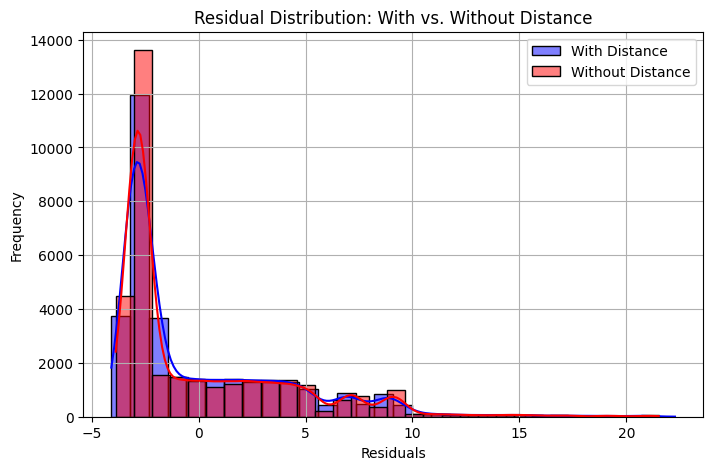

In [49]:
residuals_full = model_full.resid
residuals_no_distance = model_no_distance.resid

plt.figure(figsize=(8, 5))
sns.histplot(residuals_full, bins=30, color='blue', alpha=0.5, label="With Distance", kde=True)
sns.histplot(residuals_no_distance, bins=30, color='red', alpha=0.5, label="Without Distance", kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution: With vs. Without Distance")
plt.legend()
plt.grid(True)
plt.savefig("../plots/linear_regression/residuals.png")
plt.show()

· Residuals are highly skewed:

- The majority of residuals are concentrated near -5 to 0, meaning the model frequently underpredicts points awarded.

- There is a long right tail, indicating that some countries receive far more points than the model predicts.

· Comparing With vs. Without Distance:

- The blue curve (with distance) and the red curve (without distance) almost overlap. This means that removing distance did not significantly change the residual distribution, reinforcing the idea that distance was not a major factor in explaining Eurovision voting behavior.

· Residuals remain high regardless of model choice:

- The model struggles to explain the variation in points awarded, as seen by the wide range of residuals. This confirms the previous finding that many other unaccounted factors (political alliances, diaspora voting, cultural similarities) drive Eurovision voting.

# I HAVE'T STILL CHECKED THE NEXT SECTION -PABLO

In [5]:
country_info_path = "../data/country_info.csv"
country_info = pd.read_csv(country_info_path)

/tmp/ipykernel_14249/238078281.py:2: DtypeWarning: Columns (20,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [6]:
def analyze_country_data_by_name(country_name, data, country_info):
    """
    Analyze the relationship between distance and historical average points given by a country, 
    using the country's English name as input.

    Parameters:
    - country_name (str): English name of the country giving the votes (e.g., "Spain").
    - data (DataFrame): Dataset containing voting data with columns "from_country", "to_country", "total_points", "distance", and "year".
    - country_info (DataFrame): Dataset containing country information with columns "name" (English name) and "code" (country code).

    Output:
    - Displays a scatter plot with the regression line.
    - Prints the regression summary.
    """
    # Map the country name to its corresponding country code
    country_row = country_info[country_info["name"].str.lower() == country_name.lower()]
    if country_row.empty:
        print(f"Country "{country_name}" not found in the country information dataset.")
        return
    country_code = country_row["code"].values[0]

    # Filter the data for the specified country as the voting country
    country_data = data[data["from_country"] == country_code]

    # Calculate the average points given by the country to each other country by year
    annual_means = country_data.groupby(["to_country", "year"], as_index=False).agg({
        "total_points": "mean"
    })

    # Calculate the historical average points given by the country to each other country
    historical_means = annual_means.groupby("to_country", as_index=False).agg({
        "total_points": "mean"
    })

    # Merge the historical averages with distance data
    distance_data = country_data[["to_country", "distance"]].drop_duplicates()
    historical_means = historical_means.merge(distance_data, on="to_country", how="left")

    # Drop rows with missing values
    historical_means = historical_means.dropna()

    # Define the independent (X) and dependent (Y) variables for regression
    X_hist = historical_means["distance"]
    Y_hist = historical_means["total_points"]

    # Add a constant for the regression model
    X_hist = sm.add_constant(X_hist)

    # Fit a linear regression model
    hist_model = sm.OLS(Y_hist, X_hist).fit()

    # Plot the results
    plt.figure(figsize=(8, 5))
    plt.scatter(historical_means["distance"], historical_means["total_points"], alpha=0.7, label="Historical average points")
    plt.plot(historical_means["distance"], hist_model.predict(X_hist), color="red", label="Regression line")
    plt.title(f"Regression: Historical Avg Points vs. Distance ({country_name})")
    plt.xlabel("Distance between capitals (km)")
    plt.ylabel("Historical average points given")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the regression summary
    print(hist_model.summary())

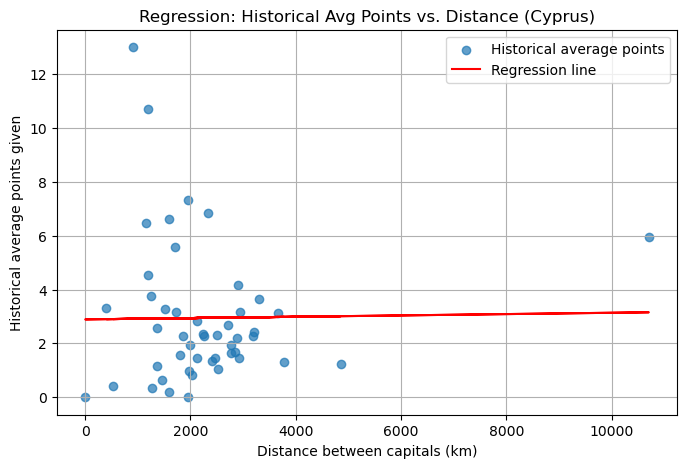

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                  0.009612
Date:                Wed, 22 Jan 2025   Prob (F-statistic):              0.922
Time:                        11:08:00   Log-Likelihood:                -114.13
No. Observations:                  48   AIC:                             232.3
Df Residuals:                      46   BIC:                             236.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8902      0.694      4.166      0.0

In [7]:
analyze_country_data_by_name("Cyprus", data, country_info)

## Without Australia:

In [8]:
def analyze_country_votes_by_name_except_Australia(country_name, data, country_info):
    """
    Analyze the relationship between distance and historical average points given by a country, 
    using the country's English name as input. Excludes any data related to Australia.

    Parameters:
    - country_name (str): English name of the country giving the votes (e.g., "Spain").
    - data (DataFrame): Dataset containing voting data with columns "from_country", "to_country", "total_points", "distance", and "year".
    - country_info (DataFrame): Dataset containing country information with columns "name" (English name) and "code" (country code).

    Output:
    - Displays a scatter plot with the regression line.
    - Prints the regression summary.
    """
    # Map the country name to its corresponding country code
    country_row = country_info[country_info["name"].str.lower() == country_name.lower()]
    if country_row.empty:
        print(f"Country "{country_name}" not found in the country information dataset.")
        return
    country_code = country_row["code"].values[0]

    # Exclude Australia-related data
    australia_code = country_info[country_info["name"].str.lower() == "australia"]["code"].values[0]
    filtered_data = data[(data["from_country"] != australia_code) & (data["to_country"] != australia_code)]

    # Filter the data for the specified country as the voting country
    country_data = filtered_data[filtered_data["from_country"] == country_code]

    # Calculate the average points given by the country to each other country by year
    annual_means = country_data.groupby(["to_country", "year"], as_index=False).agg({
        "total_points": "mean"
    })

    # Calculate the historical average points given by the country to each other country
    historical_means = annual_means.groupby("to_country", as_index=False).agg({
        "total_points": "mean"
    })

    # Merge the historical averages with distance data
    distance_data = country_data[["to_country", "distance"]].drop_duplicates()
    historical_means = historical_means.merge(distance_data, on="to_country", how="left")

    # Drop rows with missing values
    historical_means = historical_means.dropna()

    # Define the independent (X) and dependent (Y) variables for regression
    X_hist = historical_means["distance"]
    Y_hist = historical_means["total_points"]

    # Add a constant for the regression model
    X_hist = sm.add_constant(X_hist)

    # Fit a linear regression model
    hist_model = sm.OLS(Y_hist, X_hist).fit()

    # Plot the results
    plt.figure(figsize=(8, 5))
    plt.scatter(historical_means["distance"], historical_means["total_points"], alpha=0.7, label="Historical average points")
    plt.plot(historical_means["distance"], hist_model.predict(X_hist), color="red", label="Regression line")
    plt.title(f"Regression: Historical Avg Points vs. Distance ({country_name}) (Excluding Australia)")
    plt.xlabel("Distance between capitals (km)")
    plt.ylabel("Historical average points given")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the regression summary
    print(hist_model.summary())

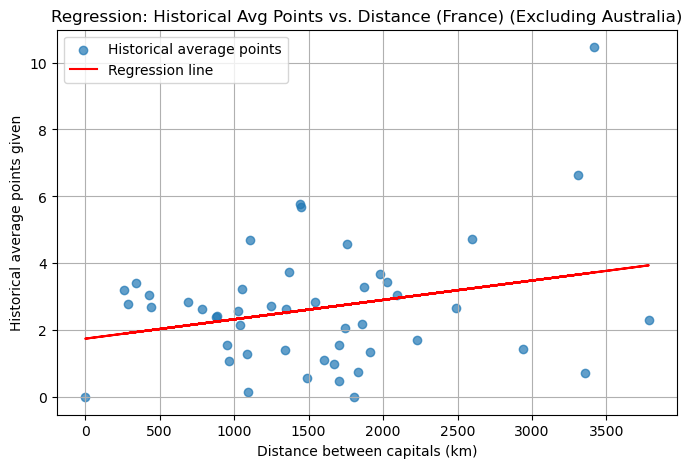

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     3.421
Date:                Wed, 22 Jan 2025   Prob (F-statistic):             0.0708
Time:                        11:08:00   Log-Likelihood:                -96.457
No. Observations:                  48   AIC:                             196.9
Df Residuals:                      46   BIC:                             200.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7492      0.553      3.166      0.0

In [9]:
analyze_country_votes_by_name_except_Australia("France", data, country_info)

### Vales Regression (Loss of Sanity)

Index(['Unnamed: 0', 'year', 'round', 'from_country', 'to_country',
       'total_points', 'tele_points', 'jury_points', 'Year_from',
       'iso-alpha-3_from', 'chrstprotpct_from', 'chrstcatpct_from',
       'chrstorthpct_from', 'judgenpct_from', 'islmgenpct_from',
       'nonreligpct_from', 'StateAbb_from', 'city_from', 'lat_from',
       'lon_from', 'GDP per capita (current US$)_from',
       'Population, total_from', 'Year_to', 'iso-alpha-3_to',
       'chrstprotpct_to', 'chrstcatpct_to', 'chrstorthpct_to', 'judgenpct_to',
       'islmgenpct_to', 'nonreligpct_to', 'StateAbb_to', 'city_to', 'lat_to',
       'lon_to', 'GDP per capita (current US$)_to', 'Population, total_to',
       'distance'],
      dtype='object')


/tmp/ipykernel_14249/3106296750.py:2: DtypeWarning: Columns (20,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


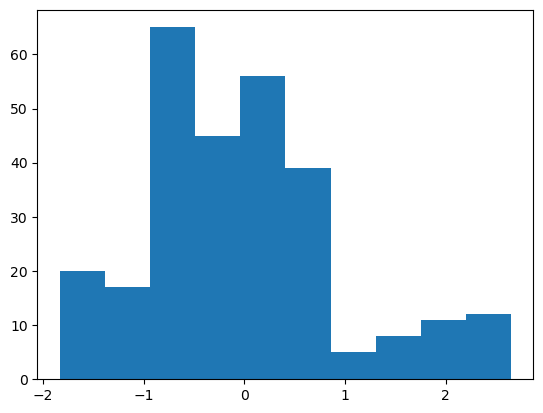

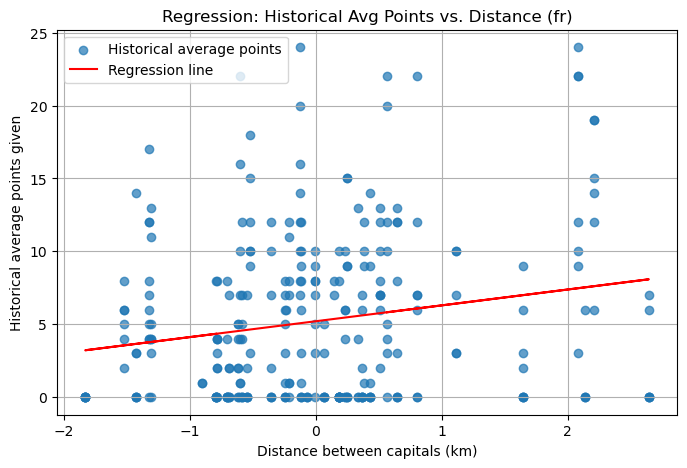

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     10.53
Date:                Wed, 22 Jan 2025   Prob (F-statistic):            0.00132
Time:                        11:32:23   Log-Likelihood:                -871.47
No. Observations:                 278   AIC:                             1747.
Df Residuals:                     276   BIC:                             1754.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
distance       1.0880      0.335      3.244      0.0

In [35]:
file_path = "../data/fulldata.csv"
data = pd.read_csv(file_path)
print(data.columns)
coutry_name = "fr"
data = data[data["from_country"] == coutry_name]
data = data[data["to_country"] != "au"]
#data= data[data["to_country"] != "il"]
data = data[data["year"] >= 2016]

data["distance"] = (data["distance"] - data["distance"].mean()) / data[
    "distance"
].std() 

data["constant"] = 1
plt.hist(data["distance"])
plt.show()
linear_model = sm.OLS( data["total_points"],data[["distance", "constant"]]).fit()
data["prediction"] = linear_model.predict(data[["distance", "constant"]])
# Plot the results
plt.figure(figsize=(8, 5))
plt.scatter(data["distance"],data["total_points"], alpha=0.7, label="Historical average points")
plt.plot(data["distance"],data["prediction"] , color="red", label="Regression line")
plt.title(f"Regression: Historical Avg Points vs. Distance ({coutry_name})") 
plt.xlabel("Distance between capitals (km)")
plt.ylabel("Historical average points given")
plt.legend()
plt.grid(True)
plt.show()

    # Print the regression summary
print(linear_model.summary())